# Evaluations for maximum likelihood

## 1. Actual data likelihood
## 2. Amari distance

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [2]:
key = jax.random.PRNGKey(1)

Introduce a perceptually uniform colormap (more colorblind friendly?).

In [3]:
import cmocean
cmap = cmocean.cm.phase
# Non-perceptually uniform alternative:
# cmap = 'hsv'

## Generate data

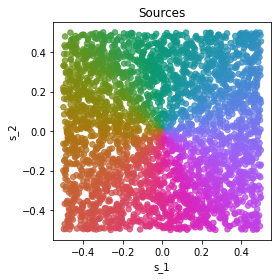

In [4]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from plotting import cart2pol, pol2cart, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

### Level of nonlinearity is related to the $a$ parameter in the Moebius transformation. When $a$ is expressed in polar coordinates, the strength of the nonlinearity can be shown to depend on the radius and on the angle. From what I saw, a radius of $\geq 3$ leads to mappings which can be learned by our residual flows (in data dimensionality of $D=2$).

In [5]:
radius = 3.0

### It is also related to the angle, but as far as I saw most angles would anyhow lead to mappings which can be resolved for radius $\geq 3$. We can sample from a rotationally invariant distribution, and then rescale the radius.

In [6]:
a = jax.random.multivariate_normal(key, mean=np.zeros(D), cov=np.eye(D))
a /= jnp.linalg.norm(a)
a *= radius

In [7]:
from mixing_functions import build_moebius_transform

# Generate a 2d rotation matrix based on a rotation angle
# angle = 45
# theta = np.radians(angle)
# c, s = np.cos(theta), np.sin(theta)
# A = np.array([[c, -s], [s, c]])

# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy
A = ortho_group.rvs(dim=D)

# The b parameter is not crucial and can be set to 0
b = 0.0 * np.ones(D) # a vector in \RR^D
# Scalar
alpha = 1.0

epsilon = 2

from jax import vmap
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=epsilon)
mixing_batched = vmap(mixing_moebius)

from jax import vmap

mixing_batched = vmap(mixing_moebius)

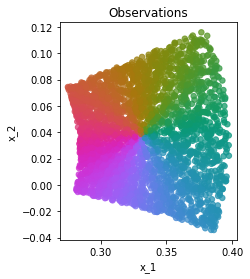

In [8]:
X = mixing_batched(S)
scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

In [9]:
unmixing_batched = vmap(unmixing_moebius)

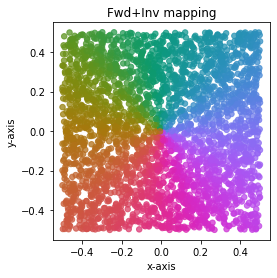

In [10]:
Y = unmixing_batched(X)
scatterplot_variables(Y[:,:2], 'Fwd+Inv mapping', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

## 1. Compute the true data likelihood

In [11]:
from metrics import observed_data_likelihood

In [12]:
jac_unmixing = jax.vmap(jax.jacfwd(unmixing_moebius))
obs_likel = observed_data_likelihood(X, jac_unmixing)
jnp.mean(obs_likel)

DeviceArray(4.396736, dtype=float32)

## Set up model

In [13]:
n_layers = 10 #32
hidden_units = [40, 40] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(D), scale=jnp.ones(D)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([TriangularResidual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [14]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, D)))

In [15]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [16]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))



In [17]:
from metrics import cima, cima_higher_d

In [18]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [19]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 1.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    # Compute the Jacobian based on current parameters
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    # Compute C_IMA based on current Jacobian
#     c_ima = cima(x, jac_fn)
    c_ima = cima_higher_d(x, jac_fn)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [20]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [21]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [22]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        params = get_params(opt_state)
        jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
        c_ima = cima_higher_d(x, jac_fn)
        print("iter=", i, "; loss=", value.item(), 
              "; -log-p=", -jnp.mean(logp.apply(params, None, x)), "; cima=", jnp.mean(c_ima)#,
#              "; loss=", -jnp.mean(logp.apply(params, None, x)) + lag_mult*jnp.mean(c_ima)
             )

iter= 0 ; loss= 2.800616502761841 ; -log-p= 2.7900064 ; cima= 9.466385e-08
iter= 2000 ; loss= -3.8740880489349365 ; -log-p= -3.8987887 ; cima= 0.00017111562
iter= 4000 ; loss= -3.925179958343506 ; -log-p= -3.943293 ; cima= 0.00142809
iter= 6000 ; loss= -3.875091552734375 ; -log-p= -3.9534922 ; cima= 0.0026047304
iter= 8000 ; loss= -4.082983493804932 ; -log-p= -4.016734 ; cima= 0.0059601255
iter= 10000 ; loss= -4.194504737854004 ; -log-p= -4.2033405 ; cima= 0.0075502973
iter= 12000 ; loss= -4.156785011291504 ; -log-p= -4.0687046 ; cima= 0.015510231
iter= 14000 ; loss= -4.180018901824951 ; -log-p= -4.19179 ; cima= 0.015297731
iter= 16000 ; loss= -4.157432556152344 ; -log-p= -4.124499 ; cima= 0.011853941
iter= 18000 ; loss= -4.144756317138672 ; -log-p= -4.1223564 ; cima= 0.016490335
iter= 20000 ; loss= -4.209190368652344 ; -log-p= -4.141149 ; cima= 0.012977241
iter= 22000 ; loss= -4.142516136169434 ; -log-p= -4.1961856 ; cima= 0.012658101
iter= 24000 ; loss= -4.239589214324951 ; -log-p= -

In [23]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

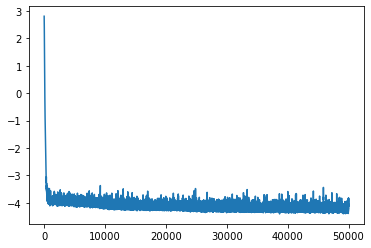

In [24]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [25]:
def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [26]:
S_rec = inv_map.apply(params_final, None, X)

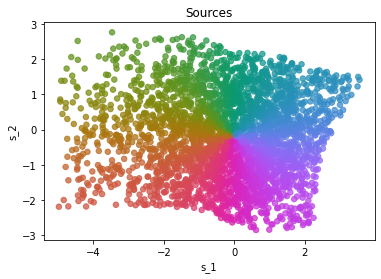

In [27]:
scatterplot_variables(S_rec[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [28]:
from jax.scipy.stats import logistic

In [29]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

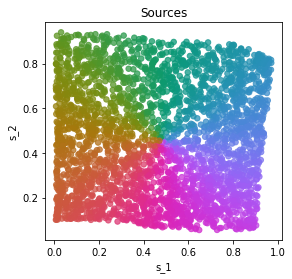

In [30]:
scatterplot_variables(S_unif[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

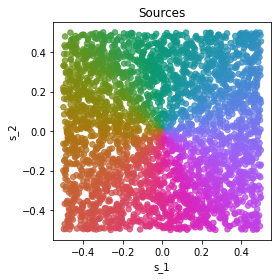

In [31]:
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

## Compute CIMA

In [32]:
# def cima(x):
#     jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
#     J = jac_fn(x)
#     detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
#     out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
#     return out

In [33]:
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
# c = cima(X, jac_fn)

In [34]:
# jnp.mean(c)

In [35]:
c_hd = cima_higher_d(X, jac_fn)
jnp.mean(c_hd)

DeviceArray(0.00140832, dtype=float32)

In [36]:
loss_final, _ = jax.value_and_grad(loss, 0)(params_final, X)
likelihood_flow = - (loss_final -lag_mult * jnp.mean(cima_higher_d(X, jac_fn)))
KL = jnp.mean(obs_likel) - likelihood_flow

In [37]:
print(KL)

0.28159285


In [38]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[ 15.886797 -66.15882 ]
 [ 42.011585   7.923867]]


In [39]:
# for i in range(2):
#     for j in range(2):
#         plt.plot(J[i,j])
#         plt.title(str(i)+","+str(j))
#         plt.show()

In [40]:
# Use the Amari distance for evaluation

## Amari distance evaluation

Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [41]:
from metrics import jacobian_amari_distance

In [42]:
# Sample P a permutation matrix
Perm = np.array([[0,1],[1,0]])# a permutation matrix

def composed_function(x):
    y = unmixing_moebius(x)
    y = y @ Perm
    z = jnp.tanh(y)
    return z

In [43]:
jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(unmixing_moebius)
# jac_r_unmix = jax.jacfwd(composed_function)
jac_t_mix = jax.jacfwd(mixing_moebius)

In [44]:
jac_r_unmix_vmap = jax.vmap(jac_r_unmix)
jac_t_mix_vmap = jax.vmap(jac_t_mix)

In [45]:
jad = jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched)

In [46]:
print(jad)

0.034429908


In [47]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?

In [48]:
jac_fn = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_fn = jax.jacfwd(unmixing_moebius)
# jac_fn = jax.jacfwd(composed_function)

In [49]:
jac_fn_batched = vmap(jac_fn)

In [50]:
c_hd = cima_higher_d(X, jac_fn_batched)
jnp.mean(c_hd)

DeviceArray(0.00140832, dtype=float32)

In [51]:
c = cima(X, jac_fn_batched)
jnp.mean(c)

DeviceArray(0.00140833, dtype=float32)

In [52]:
jnp.mean(jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched))

DeviceArray(0.03442991, dtype=float32)

## MCC based evaluation

In [53]:
from solve_hungarian import SolveHungarian

In [54]:
import numpy as np
from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment

def SolveHungarian( recov, source, correlation='Pearson' ):
    """
    compute maximum correlations between true indep components and estimated components 
    """
    Ncomp = source.shape[1]
    if correlation == 'Pearson':
        CorMat = (np.abs(np.corrcoef( recov.T, source.T ) ) )[:Ncomp, Ncomp:]
    elif correlation == 'Spearman':
        rho, _ = np.abs(spearmanr( recov, source ) )
        CorMat = rho[:Ncomp, Ncomp:]
    ii = linear_sum_assignment( -1*CorMat )

    return CorMat[ii].mean(), CorMat, ii

In [55]:
av_corr_spearman, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Spearman')
print('Spearman correlation true-recovered sources: ', av_corr_spearman)

av_corr_pearson, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Pearson')
print('Pearson correlation true-recovered sources: ', av_corr_pearson)

Spearman correlation true-recovered sources:  0.9864377894368048
Pearson correlation true-recovered sources:  0.9853466580014468


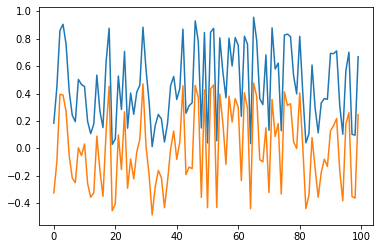

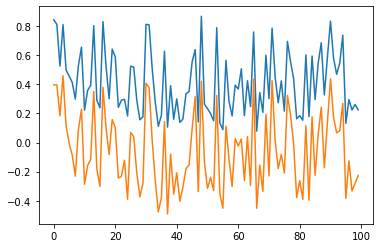

In [56]:
plt.figure()
end = 100
for i in range(S.shape[1]):
    plt.plot(S_unif[:end,indices[0][i]])
    plt.plot(S[:end, indices[1][i]])
    plt.show()